In [1]:
import os
from distributed import Client, progress
from lpcjobqueue import LPCCondorCluster
import awkward as ak
import numpy as np
import torch
from utils.mlbench import process_function
import time
import pathlib
from datetime import datetime
from utils.promqueries import get_all_queries
import matplotlib.pyplot as plt

In [2]:
def create_clusters(jobs, **kwargs):
    
    kwargs.setdefault('cores', 1)
    kwargs.setdefault('memory', '3GB')
    kwargs.setdefault('disk', '2GB')
    # by default transfer all utils and models
    kwargs.setdefault('transfer_input_files', [f'{os.getenv("BASE")}/utils', f'{os.getenv("BASE")}/models'])
    kwargs.setdefault('log_directory', None)
    kwargs.setdefault('death_timeout', 180)
    kwargs.setdefault('job_extra_directives', {})
    kwargs['job_extra_directives'].update(set_default_proxy(kwargs['job_extra_directives']))

    cluster = LPCCondorCluster(**kwargs)

    # Scaling up the cluster
    print("Generating job requests...", end='')
    cluster.scale(jobs)
    print('initial jobs generated!')
    print("Waiting for at least one worker...", end='')
    client = Client(cluster)
    client.wait_for_workers(1)
    print("workers(s) online!")
    print("Dashboard available at", client.dashboard_link)
    print("Waiting for all (%i) workers..."%jobs, end='')
    client.wait_for_workers(jobs)
    print("Done!")

    return cluster, client

def set_default_proxy(job_extra_directives):
  """
  Specifying the the grid certificate proxy to be used by the worker nodes. As
  the voms-proxy-init typically store certificates the `/tmp` directory, which is
  not accessible to the worker nodes. The returned job_extra_directives will
  setup the worker nodes to look for the proxy file in the users home directory.
  This function will also scan the input proxy file to make sure it exists and is
  valid. If the file is not found, an exception is raised with the command to
  generate the proxy file in default location.
  """
  proxyfile = ''
  if 'x509userproxy' not in job_extra_directives:
    proxyfile = '{0}/x509up_u{1}'.format(os.environ['HOME'], os.getuid())
    print('Using default proxy file:', proxyfile)
  else:
    proxyfile = job_extra_directives['x509userproxy']

  # Checking if file is a valid file
  if not os.path.isfile(proxyfile):
    raise Exception(f"""
    The proxy file {proxyfile} doesn't exist! Create the default proxy using the
    following command:
    > voms-proxy-init --voms cms --valid 192:00 --out ${{HOME}}/x509up_u${{UID}}
    """)

  return {'x509userproxy': proxyfile}

In [9]:
cluster_args = {'log_directory': '/uscmst1b_scratch/lpc1/3DayLifetime/csavard/'}
cluster, client = create_clusters(20, 
                                 **cluster_args)

Using default proxy file: /uscms/home/csavard/x509up_u51408
Generating job requests...initial jobs generated!
Waiting for at least one worker...workers(s) online!
Dashboard available at http://131.225.189.102:8787/status
Waiting for all (20) workers...


KeyboardInterrupt



In [9]:
# test if the workers have everything they need
def test_structure(x):
    import os
    import sys
    import pathlib
    test = pathlib.Path("/srv/utils/")
    success = False
    try:
        from srv.utils.mlbench import SimpleWorkLog
        success = True
    except:
        pass
    success2 = False
    try:
        from utils.mlbench import SimpleWorkLog
        success2 = True
    except:
        pass
    success3 = False
    try:
        from mlbench import SimpleWorkLog
        success3 = True
    except:
        pass
    
    return os.environ, sys.path, success, success2, success3, list(test.iterdir())

def test_triton_dask(worker):
    x = get_triton_client()
    if x is not None:
        return "success"
    else:
        return type(x)

def print_cluster_info(cluster):
    for key in cluster.scheduler_info.keys():
        if key not in ["workers"]:
            print(key, cluster.scheduler_info[key])
        else:
            print(key)
            for address, details in cluster.scheduler_info[key].items():
                print("\t", address)
                maxdkey = max([len(dkey) for dkey in details])
                for dkey, dval in details.items():
                    diff = maxdkey - len(dkey)
                    extras = " "*diff
                    extras += "  =\t"    
                    print("\t\t", dkey, extras, dval)
def test_workers(x):
    results = {}
    try:
        import os
        results["pid"] = os.getpid()
    except:
        results["pid"] = False
        
    import socket
    try:
        import socket
        results["hostname"] = socket.gethostname()
    except:
        results["hostname"] = False
        
    try:
        from utils.mlbench import SimpleWorkLog
        results["utils"] = True
    except:
        results["utils"] = False
        
    try:
        from utils.mlbench import get_triton_client
        _ = get_triton_client()
        results["triton"] = True
    except:
        results["triton"] = False
        
    try:
        from utils.mlbench import create_local_pnmodel
        _ = create_local_pnmodel()
        results["local"] = True
    except:
        results["local"] = False
    
    return results

#Test the workers can perform basic functions
test = client.gather(client.map(test_workers, range(len(cluster.workers))))

In [10]:
test

[{'pid': 20,
  'hostname': 'csavard-78095945-0-cmswn2047.fnal.gov',
  'utils': True,
  'triton': True,
  'local': True},
 {'pid': 21,
  'hostname': 'csavard-78095946-0-cmswn2114.fnal.gov',
  'utils': True,
  'triton': True,
  'local': True}]

In [ ]:
n_workers = 20
worker_hostnames = list(client.scheduler_info()['workers'].keys())

output = np.zeros((n_workers,3))
datetimes = []

for ii in range(n_workers):

    #seeds, #pseudo-events, batchsize, use triton (True/False)
    n_files = 10*(ii+1)
    n_jets = 50000*(ii+1) #will be split among all files
    workargstriton = [range(n_files), [int(n_jets/n_files)]*n_files, [1024]*n_files, [True]*n_files]

    # Triton, N workers trial
    print('Running %i jets among %i files with %i workers...'%(n_jets,n_files,ii+1))
    dt1 = datetime.now()
    futurestriton = client.map(process_function, *workargstriton, pure=False, workers=worker_hostnames[:ii+1])
    progress(futurestriton, notebook=False)
    resulttriton = client.gather(futurestriton)
    dt2 = datetime.now()
    print('Done!')
    
    datetimes.append((dt1,dt2,ii+1))
    

In [6]:
datetimes

[(datetime.datetime(2023, 4, 12, 22, 56, 16, 300043),
  datetime.datetime(2023, 4, 12, 22, 57, 40, 723960)),
 (datetime.datetime(2023, 4, 12, 22, 57, 41, 459040),
  datetime.datetime(2023, 4, 12, 22, 59, 15, 217925)),
 (datetime.datetime(2023, 4, 12, 22, 59, 15, 873967),
  datetime.datetime(2023, 4, 12, 23, 1, 25, 298433)),
 (datetime.datetime(2023, 4, 12, 23, 1, 25, 928160),
  datetime.datetime(2023, 4, 12, 23, 4, 17, 594554)),
 (datetime.datetime(2023, 4, 12, 23, 4, 18, 307498),
  datetime.datetime(2023, 4, 12, 23, 7, 50, 903470)),
 (datetime.datetime(2023, 4, 12, 23, 7, 51, 521024),
  datetime.datetime(2023, 4, 12, 23, 12, 5, 330520)),
 (datetime.datetime(2023, 4, 12, 23, 12, 5, 970292),
  datetime.datetime(2023, 4, 12, 23, 17, 2, 994242)),
 (datetime.datetime(2023, 4, 12, 23, 17, 3, 722606),
  datetime.datetime(2023, 4, 12, 23, 22, 42, 235338)),
 (datetime.datetime(2023, 4, 12, 23, 22, 43, 23140),
  datetime.datetime(2023, 4, 12, 23, 29, 3, 241365))]

In [51]:
inf = []
que = []
new_output = np.zeros((len(output),3))
for (dt1,dt2) in datetimes:
    results, queries, unique_model_versions, unique_gpu_instances = get_all_queries([(dt1,dt2)], '30s')
    #print(results['inf_rate_net'], results['inf_rate_net'][1:-1].mean())
    new_output[ii,0] = float(results['num_instances'][1:-1].mean())
    new_output[ii,1] = float(results['num_instances'][1:-1].mean())
    new_output[ii,2] = float(results['num_instances'][1:-1].mean())
    inf.append(float(results['inf_rate_net'][1:-1].mean()))
    que.append(float(results['inf_que_dur_net'][1:-1].mean()))
    #new_output[ii,2] = results['num_instances'][1:-1].mean()

In [45]:
inf

[5903.330062009301,
 11170.75,
 11737.400000000001,
 11818.5,
 11856.6,
 11917.900000000001,
 11954.7,
 11905.300000000001,
 11929.600000000002]

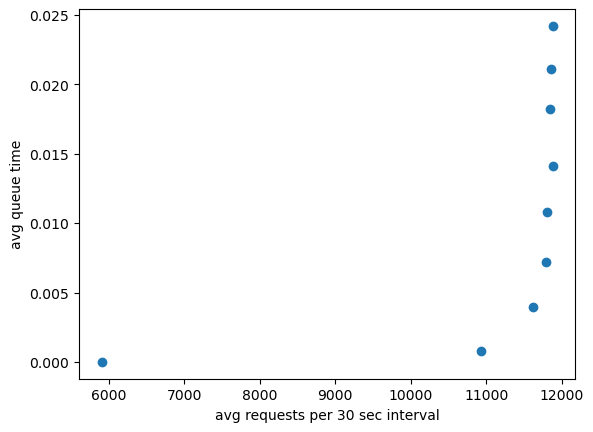

In [52]:
#plt.plot(output[:,0][output[:,0]>0],output[:,1][output[:,1]>0],'o')
plt.plot(inf,que,'o')
#plt.plot(output[:,1][output[:,1]>0],'o')
plt.xlabel('avg requests per 30 sec interval')
#plt.xlabel('# workers')
plt.ylabel('avg queue time')
plt.show()

In [10]:
cluster.close()
client.close()